# Part 1: Data sanity check

data is taken from https://www.kaggle.com/c/santander-customer-transaction-prediction

In this challenge, Santander invites Kagglers to help them identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data they have available to solve this problem.

The data is anonimyzed, each row containing 200 numerical values identified just with a number.

## Load packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
#from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential
from keras import regularizers

from sklearn.metrics import roc_auc_score, roc_curve

Using TensorFlow backend.


## Load data

In [2]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

## Basic checks

In [3]:
print (df_train.shape)
print (df_test.shape)
df_train.head()
#df_train['var_15']
#df_test.head()

(200000, 202)
(200000, 201)


,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


There are 89.951% target values with 0
There are 10.049% target values with 1


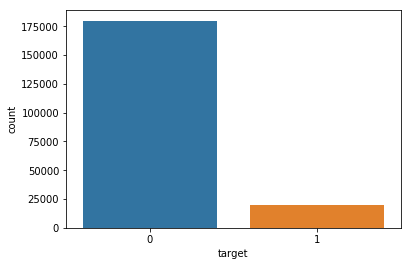

In [4]:
sns.countplot(df_train['target'])
print("There are {}% target values with 0".format(100 * df_train["target"].value_counts()[0]/df_train.shape[0]))
print("There are {}% target values with 1".format(100 * df_train["target"].value_counts()[1]/df_train.shape[0]))

Note that we have only 10% of data from class 1

## Data cleansing

### Check missing data and data types

In [5]:
# useful function from https://www.kaggle.com/gpreda/santander-eda-and-prediction
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))


In [6]:
missing_data(df_train)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [7]:
missing_data(df_test)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


Everything seems to be filled. Now let's prepare data for future usage in NN

In [8]:
Y_train_full = df_train['target']
X_train_full = df_train.drop(['target', 'ID_code'], axis=1)

X_train_0_full = (df_train.loc[lambda x: x['target'] < 1, :]).drop(['ID_code'], axis=1)
X_train_1 = (df_train.loc[lambda x: x['target'] > 0, :]).drop(['ID_code'], axis=1)
#X_train_0 = X_train_0_full.head(10)
X_train_0 = X_train_0_full.head(20098)
#X_train_0 = X_train_0_full.head(45000)
#X_train_0 = X_train_0_full.head(100000)
#X_train_0 = X_train_0_full

df_train_sample = pd.concat([X_train_1,X_train_0]).sample(frac=1) #merge 2 dataframes and reshuffle
#df_train_sample.head(10)
X_train = df_train_sample.drop(['target'],axis=1)
Y_train = df_train_sample['target']

#X_train =  pd.concat([X_train_1,X_train_0]).drop(['target'],axis=1)
#X_train =  X_train.drop([],axis=0)
#Y_train =  pd.concat([X_train_1,X_train_0])['target']
#Y_train =  Y_train.drop([],axis=0)

X_test = df_test.drop(['ID_code'], axis=1)
#X_train.head(10)
#Y_train.head()
#X_train.head()

### Check for outliers

In [9]:
#Outliers? -> does not help really

def detect_outlier(data_1):
    outliers=[]
    threshold=5
    mean_1 = np.mean(data_1)
    std_1 =np.std(data_1)
    #print (mean_1, std_1)
    for y in data_1:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

In [10]:
means_train=[]
stds_train=[]
means_train_0=[]
stds_train_0=[]
means_train_1=[]
stds_train_1=[]

means_test=[]
stds_test=[]

for i in range (200):
    name = 'var_'+str(i)
    if(X_train[name].std()>20):
        print("hm, very high std! ", name, "train mean = ", X_train[name].mean(), "std = ",X_train[name].std())
        print("For the same var: test mean = ", X_test[name].mean(), "std = ",X_test[name].std())
        #remove it for simplysity
    #    X_train = X_train.drop([name], axis=1)
    #    X_test = X_test.drop([name], axis=1)
    #else:   
    means_train.append(X_train[name].mean())
    stds_train.append(X_train[name].std())    
    means_train_0.append(X_train_0[name].mean())
    stds_train_0.append(X_train_0[name].std())    
    means_train_1.append(X_train_1[name].mean())
    stds_train_1.append(X_train_1[name].std())    
    means_test.append(X_test[name].mean())
    stds_test.append(X_test[name].std())
    
    if(detect_outlier(X_train[name])):
        print (name, detect_outlier(X_train[name]))
        #remove variables with outliers
        X_train = X_train.drop([name], axis=1)
        X_test = X_test.drop([name], axis=1)
        X_train_full = X_train_full.drop([name], axis=1)
    if(i==68 or i==12 or i==15 or i==14):
        print (name, detect_outlier(X_train[name]))
        #remove variables with outliers
        X_train = X_train.drop([name], axis=1)
        X_test = X_test.drop([name], axis=1)
        X_train_full = X_train_full.drop([name], axis=1)
print (X_train.shape)
#print (X_train_0.shape)
#print (X_train_1.shape)
print (X_test.shape)

var_12 []
var_14 []
var_15 []
hm, very high std!  var_45 train mean =  -13.336038297343087 std =  21.432273388833067
For the same var: test mean =  -12.666094574499892 std =  21.402708162073154
var_68 []
(40196, 196)
(200000, 196)


/home/anastasia/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


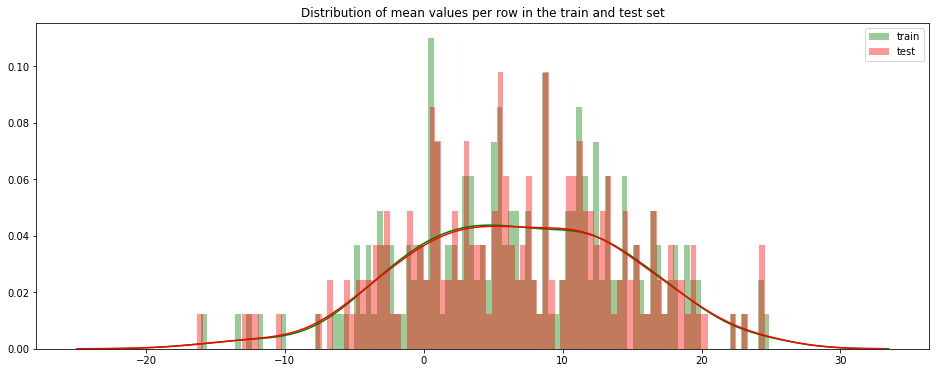

In [11]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(means_train,color="green", kde=True,bins=100, label='train')
sns.distplot(means_test,color="red", kde=True,bins=100, label='test')
plt.legend()
plt.show()


    

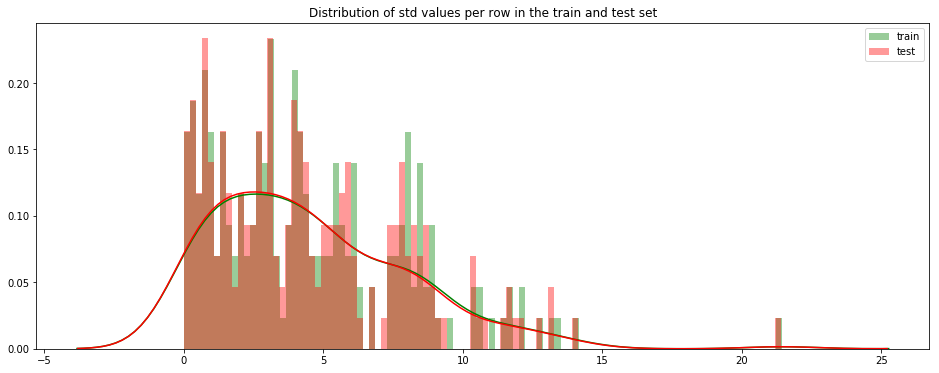

In [12]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(stds_train,color="green", kde=True,bins=100, label='train')
sns.distplot(stds_test,color="red", kde=True,bins=100, label='test')
plt.legend()
plt.show()

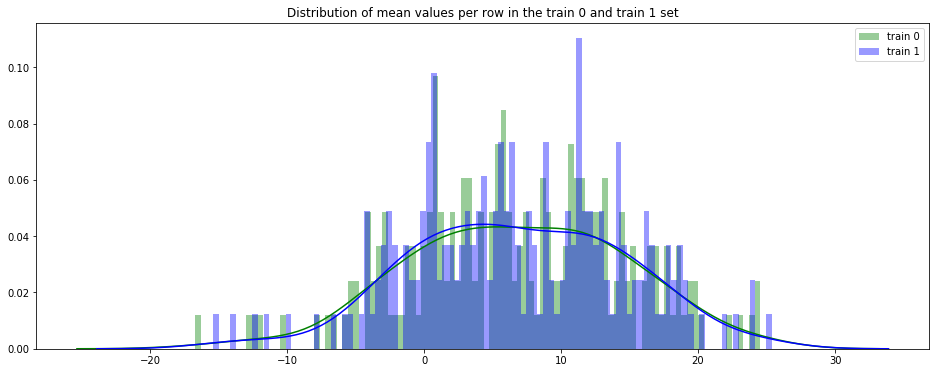

In [13]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per row in the train 0 and train 1 set")
sns.distplot(means_train_0,color="green", kde=True,bins=100, label='train 0')
sns.distplot(means_train_1,color="blue", kde=True,bins=100, label='train 1')
plt.legend()
plt.show()

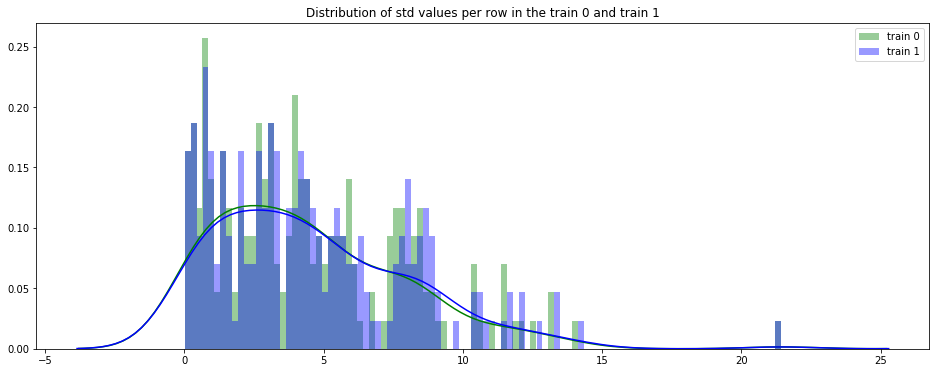

In [14]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train 0 and train 1")
sns.distplot(stds_train_0,color="green", kde=True,bins=100, label='train 0')
sns.distplot(stds_train_1,color="blue", kde=True,bins=100, label='train 1')
plt.legend()
plt.show()

### Correlations


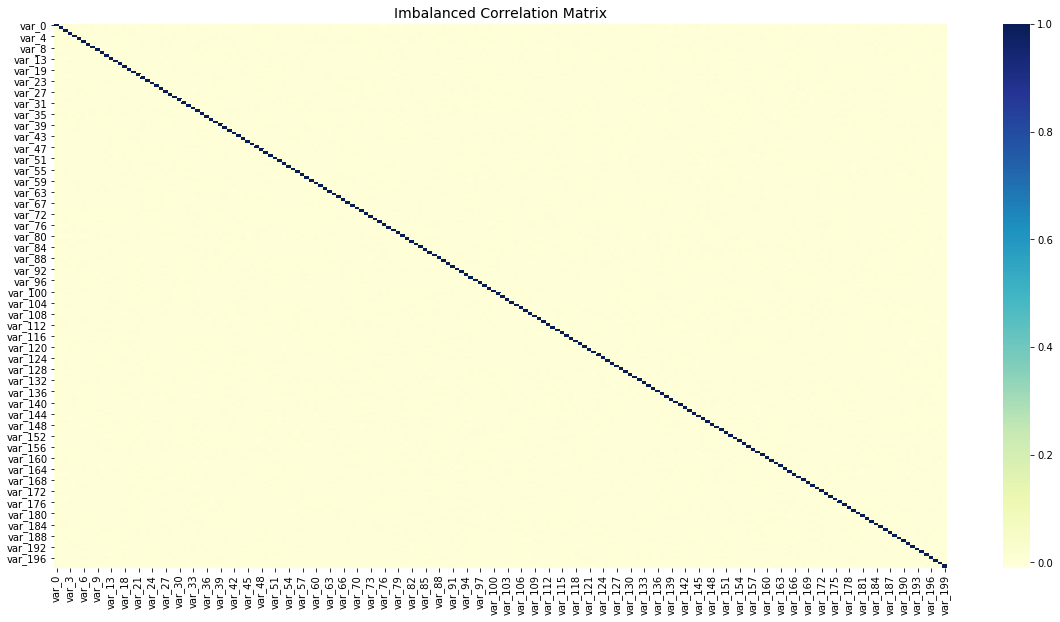

In [15]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = X_train_full.corr(method='pearson', min_periods=100)
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

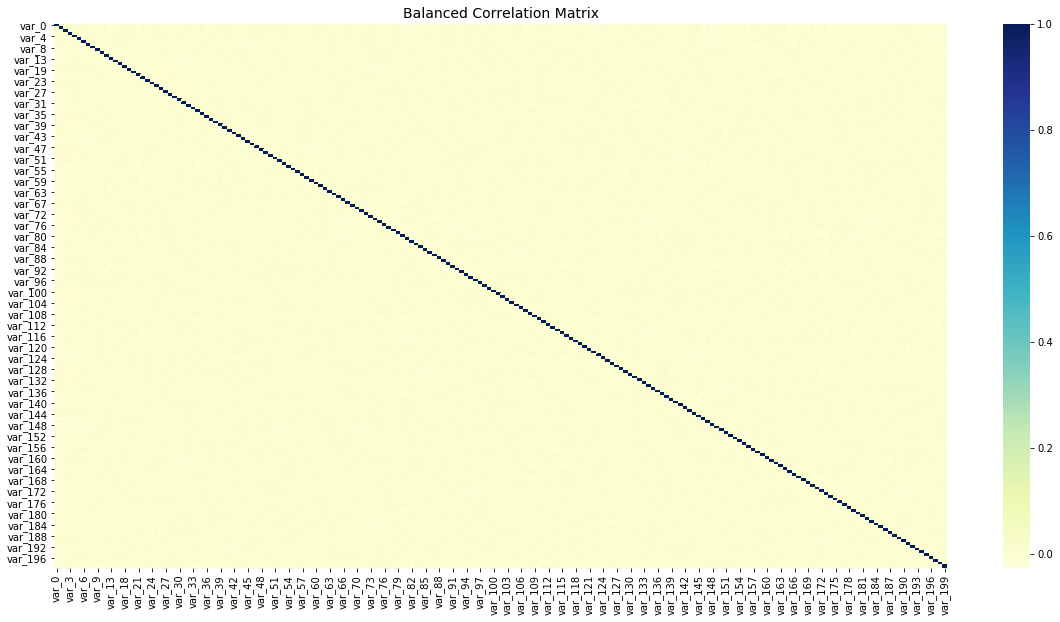

In [16]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = X_train.corr(method='pearson', min_periods=100)
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Balanced Correlation Matrix", fontsize=14)

plt.show()

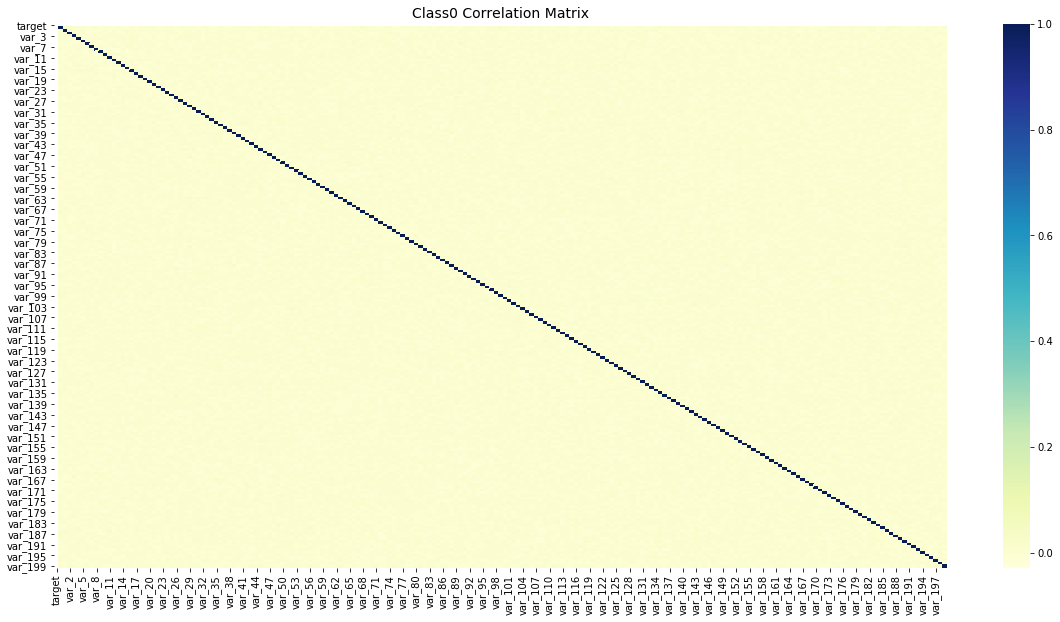

In [17]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = X_train_0.corr(method='pearson', min_periods=100)
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Class0 Correlation Matrix", fontsize=14)

plt.show()


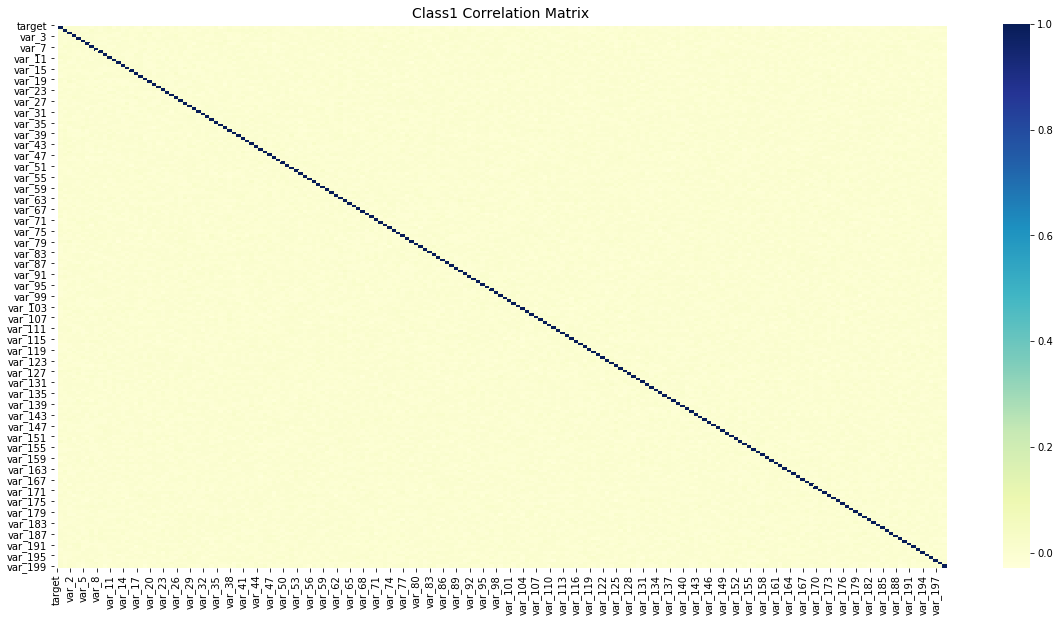

In [18]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = X_train_1.corr(method='pearson', min_periods=100)
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Class1 Correlation Matrix", fontsize=14)

plt.show()

## Prepare data for NN

In [19]:
# ##Standardize features by removing the mean and scaling to unit variance
# sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)
# X_train_full_std = sc.transform(X_train_full)

# #X_train_std = X_train
# #X_test_std = X_test
# #X_train_full_std = X_train_full


In [20]:
#Split into train and validation datasets
# X_train_NN ,X_val_NN ,Y_train_NN , Y_val_NN = train_test_split(X_train_std,Y_train,test_size=0.40,random_state=45)

# Part2: Train and test model

## Build Model

In [21]:
import tensorflow as tf
from keras import backend as K
# Add RUC metric to monitor NN
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc


In [22]:
#from keras.constraints import max_norm
#def build_NN():
#    model = Sequential()
## Input layer
#    model.add(Dense(units = 8, activation = "relu", input_dim = X_train_NN.shape[1], kernel_initializer = "normal", kernel_regularizer=regularizers.l2(0.005), 
#                kernel_constraint = max_norm(5.)))
## Add dropout regularization
#    model.add(Dropout(rate=0.2))

## First hidden layer
#    model.add(Dense(units = 4, activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_constraint=max_norm(5)))
## Add dropout regularization
#    model.add(Dropout(rate=0.1))
#
## Second hidden layer
##    model.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.005), kernel_constraint=max_norm(5)))
## Add dropout regularization
##    model.add(Dropout(rate=0.1))
#
## Third hidden layer
#    model.add(Dense(4, activation='tanh', kernel_regularizer=regularizers.l2(0.005), kernel_constraint=max_norm(5)))
## Add dropout regularization
#    model.add(Dropout(rate=0.1))
#
## Output layer
#    model.add(Dense(units = 1, activation='sigmoid'))
#
#    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', auc])
#    model.summary()
#    return model

In [23]:
#def build_NN():
#    NN = Sequential()
#    NN.add(Dense(16,input_dim = X_train_NN.shape[1], 
#                         activation='relu', kernel_regularizer=regularizers.l2(0.005)))
#    # NN.add(Dense(1028
#    NN.add(Dropout(rate=0.4))
#    #NN.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
#    #NN.add(Dropout(rate=0.2))
#    NN.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
#    NN.add(Dropout(rate=0.2))
#    #NN.add(Dense(1, activation='relu', kernel_regularizer=regularizers.l2(0.005)))
#    NN.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.001)))
#    # Compiling model
#    NN.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
#    #NN.compile(optimizer='adam', loss='hinge', metrics=['accuracy'])
#   # NN.compile(optimizer='sgd', loss='mean_absolute_error', metrics=['accuracy'])
#    NN.summary()
#    return NN

In [24]:
#model_NN = build_NN()
#history = model_NN.fit(X_train_NN,Y_train_NN,validation_data = (X_val_NN,Y_val_NN),epochs=20,batch_size=5000)

## Part 2.1 try BalancedBaggingClassifier


In [25]:
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
X_train_bbc ,X_val_bbc ,Y_train_bbc , Y_val_bbc = train_test_split(X_train_full,Y_train_full,test_size=0.33,random_state=45)
#base_estimator = AdaBoostClassifier(base_estimator=GradientBoostingClassifier(max_depth=5, learning_rate=0.9),n_estimators=20)
#bbc = BalancedBaggingClassifier(n_estimators=10,base_estimator=base_estimator, random_state=42, max_samples = 0.5)
base_estimator = AdaBoostClassifier(n_estimators=10) 
bbc = RUSBoostClassifier(n_estimators=100,base_estimator=base_estimator,sampling_strategy=1.0)
#bbc.fit(X_train_bbc, Y_train_bbc)
#Y_pred = bbc.predict(X_val_bbc)
#print(confusion_matrix(Y_val_bbc, Y_pred))
#print (balanced_accuracy_score(Y_val_bbc, Y_pred)) 

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {
   # 'base_estimator__max_depth' : [5, 10, 20, 30],
   # 'base_estimator__loss' : ['deviance', 'exponential'],
   # 'base_estimator__min_impurity_decrease' : [0.0, 0.01, 0.1],
    'base_estimator__learning_rate' : [0.5],
    'base_estimator__n_estimators' : [500],
    'n_estimators' : [100],
     #'max_samples' : [0.05, 0.1, 0.2, 0.5],    
    'sampling_strategy':[1.00]
}
base_estimator = AdaBoostClassifier()
##base_estimator = GradientBoostingClassifier()
clf = GridSearchCV(RUSBoostClassifier(base_estimator=base_estimator), param_grid, cv=3, scoring='roc_auc', n_jobs=10)


In [27]:
clf.fit(X_train_bbc, Y_train_bbc)
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)
Y_pred = clf.predict(X_val_bbc)
print ("balanced accuracy score:")
print (balanced_accuracy_score(Y_val_bbc, Y_pred)) 

Best parameter (CV score=0.894):
{'base_estimator__learning_rate': 0.5, 'base_estimator__n_estimators': 500, 'n_estimators': 100, 'sampling_strategy': 1.0}
balanced accuracy score:
0.8120689759131923


[[49086 10279]
 [ 1345  5290]]

misid 0 as 1: 17.314916196412028
misid 1 as 0: 20.27128862094951


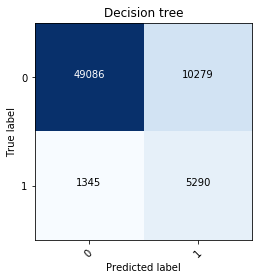

In [28]:
# useful function from 
# https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/ensemble/plot_comparison_ensemble_classifier.html#sphx-glr-auto-examples-ensemble-plot-comparison-ensemble-classifier-py
import itertools

def plot_confusion_matrix(cm, classes, ax,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    print(cm)
    print('')

    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.sca(ax)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    
cm_tree = confusion_matrix(Y_val_bbc, Y_pred)
fig, ax = plt.subplots()
plot_confusion_matrix(cm_tree, classes=np.unique(Y_pred), ax=ax,
                      title='Decision tree')
print("misid 0 as 1:", (100*cm_tree[0,1])/float(cm_tree[0,0]+cm_tree[0,1]))
print("misid 1 as 0:", (100*cm_tree[1,0])/float(cm_tree[1,0]+cm_tree[1,1]))

# Part3: check result

In [29]:
#validations = model_NN.predict(X_val_NN).ravel()
#fpr, tpr, thresholds = roc_curve(Y_val_NN, validations)
#validations = model_NN.predict(X_train_full_std).ravel()
#validations =  bbc.predict(X_val_bbc).ravel()
validations =  clf.predict(X_val_bbc).ravel()
fpr, tpr, thresholds = roc_curve(Y_val_bbc, validations)
print('auc:', metrics.auc(fpr, tpr))
print(pd.Series(validations).mean())


auc: 0.8120689759131923
0.2358939393939394


In [30]:
#Count correct and wrong predictions
count_val_0 = 0
count_val_1 = 0
count_true_0 = 0
count_true_1 = 0

#predictions_train = model_NN.predict(X_val_NN)
#predictions_train = bbc.predict(X_val_bbc)
predictions_train = clf.predict(X_val_bbc)
for i in range(len(predictions_train)):
    if predictions_train[i]<0.5:
        predictions_train[i] = int(0)
        count_val_0 +=1
    else:
        predictions_train[i] = int(1)
        count_val_1 +=1
    
count_true_0 = Y_val_bbc.value_counts()[0]
count_true_1 = Y_val_bbc.value_counts()[1]

print("pred to true for 0: ", count_val_0, "/", count_true_0, "=", float(count_val_0)/float(count_true_0))
print("pred to true for 1:", count_val_1, "/", count_true_1, "=", float(count_val_1)/float(count_true_1))



pred to true for 0:  50431 / 59365 = 0.8495072854375474
pred to true for 1: 15569 / 6635 = 2.3464958553127353


In [31]:
## Plot training & validation loss values
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
#plt.title('Model loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

## Plot training & validation auc values
#plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
#plt.title('Model acc')
#plt.ylabel('Auc')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

#plt.plot(history.history['auc'])
#plt.plot(history.history['val_auc'])
#plt.title('Model auc')
#plt.ylabel('Auc')
#plt.xlabel('Epoch')
#plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()

In [32]:
#predictions = model_NN.predict(X_test_std)
#predictions = bbc.predict(X_test)
predictions = clf.predict(X_test)
count_0 = 0
count_1 = 0
for i in range(len(predictions)):
    if predictions[i]<0.5:
        predictions[i] = int(0)
        count_0 +=1
    else:
        predictions[i] = int(1)
        count_1 +=1


In [33]:
#sns.countplot(predictions)
print("There are {}% target values with 0".format(100 * count_0/len(predictions)))
print("There are {}% target values with 1".format(100 * count_1/len(predictions)))

There are 76.4425% target values with 0
There are 23.5575% target values with 1


# Part4: create submition

In [34]:
!mv sub.csv old_sub.csv

In [35]:
sub = pd.read_csv('sample_submission.csv')
sub['target'] = predictions
sub.to_csv('sub.csv', index=False)